# RNN Tweet Classification (Final Report)

[LINK TO PROJECT REPO](https://github.com/rpforrest1/RNN_Tweet_Classification_Project)

## Introduction

This project was created as a submission for the Natural Language Processing with Disaster Tweets Kaggle competition here: [Kaggle NLP Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). The purpose of the project is to create an algorithm that will detect if a tweet is related to a disaster, which would be an event that caused some type of damage or loss of life. This dataset was created by the company figure-eight (now owned by Appen) and originally shared on their website. 

In this project, I intend to build an RNN model that will perform binary classification of tweet text data. I'll go through the exploratory data analysis, the model architecture while doing hyperparameter tuning, and the final results.

In [1]:
# Remove TF logging warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from model_building.model_helper_functions import plot_metric, plot_learning_rate, bold
from model_building.data_pipeline import predict_on_kaggle_test_set, clean_text
import tensorflow as tf

In [3]:
# Remove TF logging warnings
tf.get_logger().setLevel('ERROR')

In [4]:
# If the kaggle submission file was already created, set to False.
CREATE_SUBMISSION_FILE = False

There is a single csv file the contains the training data. I'll do a quick check to make sure the table contains no null values. 

In [5]:
data_dir = './data'
df = pd.read_csv(f'{data_dir}/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
display(df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print(f'This dataset contains a total of {len(df)} tweets.')

This dataset contains a total of 7613 tweets.


In the overview for the kaggle project, it was stated that the **keyword** column contains a particular keyword from the tweet and the **location** column contains the location the tweet was sent from. Both of these columns are allowed to have blanks (which we confirmed with the dataframe.info from earlier). I intend to ignore these 2 columns for now and just focus on the **text** column which contains the tweet text.

For the keyword and location columns, I will fill in the blanks with 'unknown'.

In [8]:
df['keyword'].fillna('unknown', inplace=True)
df['location'].fillna('unknown', inplace=True)

---

## Exploratory Data Analysis

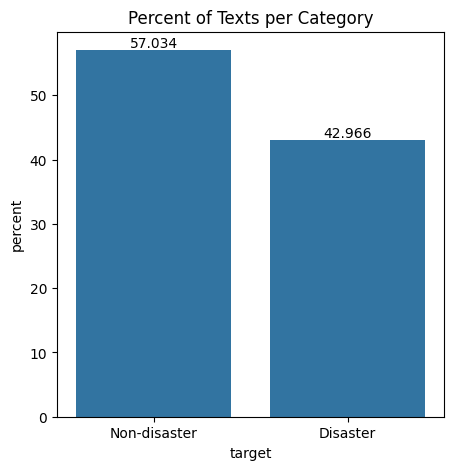

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
_ = sns.countplot(df, x='target', ax=ax, stat='percent', formatter=(lambda x: 'Disaster' if x else 'Non-disaster'))
plt.title('Percent of Texts per Category')
plt.bar_label(ax.containers[0])
plt.show()

From the chart above, we can see that there is some imbalance in the dataset, with the majority of the labels being non-disaster. This is what I would expect in reality since disasters aren't events that should be happening more frequently than not. Due to the imbalance, I will alter my training strategy by making sure stratified sampling is performed.

In [10]:
print(bold('Examples of Disaster tweets'), '\n')
for text in df[df['target'] == 1]['text'].iloc[:100:20]:
    print('-', text, '\n')

Examples of Disaster tweets 

- Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

- Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k 

- FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999 PINER RD/HORNDALE DR 

- #Horrible #Accident Man Died In Wings Airplane (29-07-2015) #WatchTheVideo http://t.co/p64xRVgJIk 

- The shooting or the airplane accident  https://t.co/iECc1JDOub 



In [11]:
print(bold('Examples of Non-disaster tweets'), '\n')
for text in df[df['target'] == 0]['text'].iloc[:100:20]:
    print('-', text, '\n')

Examples of Non-disaster tweets 

- What's up man? 

- Ablaze for you Lord :D 

- http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice &amp; see how a #solicitor can help #OtleyHour 

- Aftershock was the most terrifying best roller coaster I've ever been on. *DISCLAIMER* I've been on very few. 

- Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night. 



Overall the text from tweet data isn't exactly the cleanest. Its common for tweets to have links, @username symbols and #'s. I plan to remove links and @usernames. #'s when its multiple words like #ForestFire are often in this Pascal Case. If possible, I will also split all words in Pascal Case into multiple words. I will also do some other cleaning such as dropping accent characters, any non-word characters, and any extra spaces.  

Before cleaning the field, I'll make a copy of it in order to go back and compare if needed.

In [12]:
df['og_text'] = df['text']
df['text'] = df['text'].apply(clean_text)

In [13]:
print(bold('Examples of Disaster tweets (after cleaning)'), '\n')
for text in df[df['target'] == 1]['text'].iloc[:100:20]:
    print('-', text, '\n')

Examples of Disaster tweets (after cleaning) 

- Our Deeds are the Reason of this earthquake May ALLAH Forgive us all 

- Deputies Man shot before Brighton home set ablaze  

- FYI CAD FYI ACCIDENT PROPERTY DAMAGE NHS PINER RD HORNDALE DR 

-  Horrible Accident Man Died In Wings Airplane Watch The Video  

- The shooting or the airplane accident  



In [14]:
print(bold('Examples of Non-disaster tweets (after cleaning)'), '\n')
for text in df[df['target'] == 0]['text'].iloc[:100:20]:
    print('-', text, '\n')

Examples of Non-disaster tweets (after cleaning) 

- What up man  

- Ablaze for you Lord D 

-  Had personalinjury accident this summer Read our advice see how solicitor can help Otley Hour 

- Aftershock was the most terrifying best roller coaster ve ever been on DISCLAIMER ve been on very few  

- Aftershock back to school kick off was great want to thank everyone for making it possible What great night  



The text is now a lot less messy. Further standardization of the text, such as converting to lowercase, will be done when the model is trained.

Even though I do not have a plan to use the keyword and location columns, I am curious about what the most common values are.

In [15]:
print(bold('Top 10 most common keyword values.'))
display(df['keyword'].value_counts().head(10))

Top 10 most common keyword values.


keyword
unknown        61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: count, dtype: int64

Its possible that this column could be useful, given that there isn't many unknown values. This column could allow us to categorize the type of emergency. It also looks like the keyword column needs to be cleaned slightly, so I will replace the '%20' with a blank space.

In [16]:
df['keyword'] = df['keyword'].str.replace('%20', ' ')

In [17]:
print(bold('Top 10 most common location values.'))
display(df['location'].value_counts().head(10))

Top 10 most common location values.


location
unknown            2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64

The location column looks like it will not be helpful for this analysis. I will not do anything extra to this column.

---

## Model Architecture and Tuning

Outside of a few model architectures shared by tensorflow [provided here](https://www.tensorflow.org/text/tutorials/text_classification_rnn), I do not have a definite configuration to go with. I decided to run many models in a separate notebook at [this notebook link](https://github.com/rpforrest1/RNN_Tweet_Classification_Project/blob/main/model_building/Multi_Model_Building_trained.ipynb), and choose the best one. Each model will have use a training, validation and test set with a 70/22.5/7.5 split.

I'll walk through each configurable option from the python code in more detail. Some configurations were reduced to single values due to the large number of total models being created.
- `vocab_sizes = [4000]`: This represents the maximum number of words that will be in the vocabulary. Any words not included will be marked as \[UNK] for unknown. This parameter is used by tensorflow's TextVectorization layer. This layer also automatically lowercases and strips punctuation from the text before doing the tokenization.
- `embed_sizes_with_pretrained_model = [[100,'glove-wiki-gigaword-100'],[300,'word2vec-google-news-300'],[200, None]]`: This represents the embedding size and the pretrained model to use. If looking at the first index for example, it says to use an embedding size of 100 and the glove-wiki-gigaword-100 pretrained model (provided by the gensim library). If the pretrained model is None, it means that the embedding will be trained within the neural network. If a pretrained model is used, the number of words recognized will be lower than the vocabulary since not every word we start out with, will also appear in the pretrained embedding. I wanted to test out a pretained glove and word2vec model and see if its better than what can be created through training alone. In cases where a pretrained model is used, the weights are frozen. The embedding size provided will be the deminsion that the vocabulary is ultimately turned in to that is then fed as the input into the RNN layer.
- `batch_sizes = [32, 64]`: This represents the batch size to use for training.
- `bidirectional_options = [True, False]`: This represents whether or not the RNN layer should be bidirectional, meaning that it propagates the input forward and backwards through the RNN layer and then concatenates the final output. Using bidirectional for text data is said to be beneficial.
- `rnn_layers = [layers.GRU, layers.LSTM]`: This represents what type of RNN layer will be used for the entire model. I am only wanting to test GRU and LSTM since they are improvements to vanilla RNN.
- `rnn_units_configs = [[8],[32],[32, 16]]`: This represents the number of RNN layers and the number of units in that layer. For example, the final index says to use 32 units in the first RNN layer and 16 units in the final RNN layer. I am not sure how the layer count and unit count affects the model, so I'm very curious how this plays into the results.
- `dense_units_configs = [[1],[32,1]]`: This represents the number of dense layers and the number of units in that layer. The dense layers will go after the RNN layers. This configuration works similarly to the rnn_units_configs.
- `activations = ['sigmoid']`: This represents the activation function to use for all of the dense layers.
- `final_dropouts = [0.5]`: This represent the dropout percentage to use for the single dropout layer right before the dense layer that has a single unit. The should help prevent overfitting.
- `optimizers = [RMSprop, Adam]`: This represents the optimizer to use for the model. The default configuration will be used in each case.

Outside of all the parameter configurations, the model training will also utilize early stopping with a patience of 3, learning rate reduction with a patience of 1, and a max epoch of 15. This should also help reduce overfitting in all cases.  

With all of the configuration options, there were a total of **288** models to fit. I'll read in the results and go through them to see what can be learned.

In [18]:
def load_results(model_checkpoint_dir:str):
    """
    Loads in the model results.

    Args:
        model_checkpoint_dir: The directory for the model checkpoint files.
    
    Returns:
        progress: A dataframe that tracked the model training progress. This dataframe shows the
            parameters used for the model.
        model_data: A dictionary that provides the model id, checkpoint location, and model history.
        all_test_metrics: A dataframe that contains the test metrics for all models loaded.
        full_results: A dataframe that combines the all_test_metrics and progress dataframes.
    """
    
    # During the model training, a model_building_progress file was created to track the training of all the models.
    progress = pd.read_csv(f'{model_checkpoint_dir}/model_building_progress.csv')
    progress['model'] = progress['model'].apply(lambda x: f'model{x}')
    progress.set_index('model', inplace=True)

    # Reading in the model history and test results
    model_data = dict()
    all_test_metrics = []
    files = os.listdir(model_checkpoint_dir)

    # Loading data for each trained model
    for file in files:
        if re.match('model\d+', file):
            model_data[file] = {
                'id':int(re.findall('\d+', file)[0]),
                'checkpoint':f'{model_checkpoint_dir}/{file}/cp.ckpt',
                'model_history':pd.read_json(f'{model_checkpoint_dir}/{file}/model_history.json'),
            }
            
            test_metrics = pd.DataFrame(json.load(open(f'{model_checkpoint_dir}/{file}/test_metrics.json')), index=[file])
            model_data[file]['test_metrics'] = test_metrics
            all_test_metrics.append(test_metrics)
    
    all_test_metrics = pd.concat(all_test_metrics)
    full_results = all_test_metrics.join(progress.astype(str))
    full_results.sort_values('f1_score', inplace=True, ascending=False)

    return progress, model_data, all_test_metrics, full_results

In [19]:
progress, model_data, all_test_metrics, full_results = load_results('./model_building/model_checkpoints')

In [20]:
for col in [c for c in all_test_metrics.columns if c not in ['loss', 'total_time', 'precision', 'recall']]:
    print(bold(f'Top {col} values on test dataset.'))
    display(all_test_metrics.sort_values(col, ascending=False).head(3))
    print('---')

Top accuracy values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model97,0.394028,0.852890,0.897646,0.892683,0.746939,0.813333,84.418368
model105,0.386823,0.851138,0.900532,0.866973,0.771429,0.816415,162.182242
model145,0.392399,0.849387,0.899937,0.876777,0.755102,0.811403,87.983418


---
Top auc values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model104,0.385789,0.847636,0.901628,0.865741,0.763265,0.811280,142.008245
model107,0.388596,0.826620,0.900933,0.865000,0.706122,0.777528,81.277768
model152,0.388419,0.840630,0.900776,0.856481,0.755102,0.802603,132.943307


---
Top f1_score values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model105,0.386823,0.851138,0.900532,0.866973,0.771429,0.816415,162.182242
model97,0.394028,0.852890,0.897646,0.892683,0.746939,0.813333,84.418368
model145,0.392399,0.849387,0.899937,0.876777,0.755102,0.811403,87.983418


---


Each of the models shown above are good in their own way. The scoring criteria for the kaggle competition is the F1-score. I am unsure how well my test set compares to the kaggle test set, so I will choose 4 of the best models and submit them to see if the scores line up.

In [21]:
for model_name in ['model105', 'model97', 'model145', 'model104']:
    if CREATE_SUBMISSION_FILE:
        model = tf.keras.models.load_model(model_data[model_name]['checkpoint'])
        final_activation = progress.at[model_name, 'activation']
        model_submission = predict_on_kaggle_test_set(data_dir, model=model, final_activation=final_activation)
        model_submission.to_csv(f'./submissions/{model_name}_submission.csv', index=False)
    else:
        print(f'Submission file already created for {model_name}.')

Submission file already created for model105.
Submission file already created for model97.
Submission file already created for model145.
Submission file already created for model104.


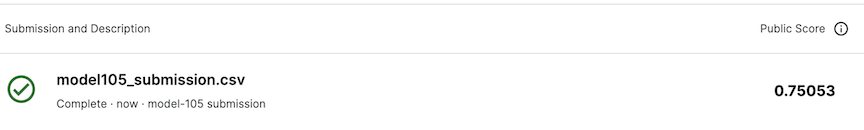  
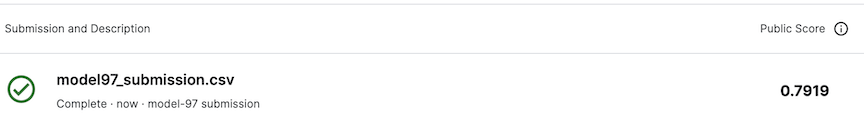  
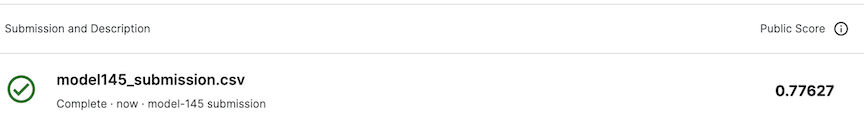  
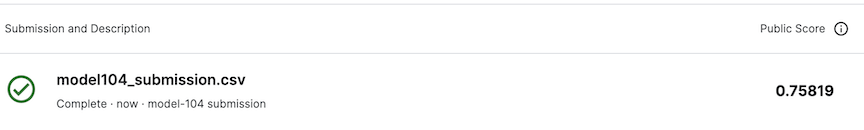  

So from best to worse for the kaggle scores, it goes model-97 => model-145 => model-104 => model-105. This is somewhat unexpected, so I believe there is some overfitting happening. I'll take a look at the configurations used for these models in order to learn more about what is happening.

In [22]:
print(bold('Model configuration for model-97'))
display(progress.loc['model97'])

Model configuration for model-97


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model97, dtype: object

In [23]:
print(bold('Model configuration for model-145'))
display(progress.loc['model145'])

Model configuration for model-145


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         64
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model145, dtype: object

In [24]:
print(bold('Model configuration for model-104'))
display(progress.loc['model104'])

Model configuration for model-104


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                    [32, 16]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                     RMSprop
finished                                                         True
Name: model104, dtype: object

In [25]:
print(bold('Model configuration for model-105'))
display(progress.loc['model105'])

Model configuration for model-105


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                    [32, 16]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model105, dtype: object

Here are some takeaways after reviewing the configurations.
- The embedding size of 300 while using the pretrained word2vec-google-news-300 model is the overall best. This particular configuration also has the highest embedding size, so I am curious if the embedding size should be increased.
- A batch size of 32, bidirectional GRU layers with an Adam optimizer, and a single unit dense layer appears to be best overall with other configs yielding no benefits in particular.
- Having multiple RNN layers isn't necessarily better than a single RNN layer.
- Having a high number of units in the RNN layer doesn't appear to make a large difference.

I will create some plots to see if my takeaways were generally true for the 288 trained models. **(The extreme tails may be misleading)**

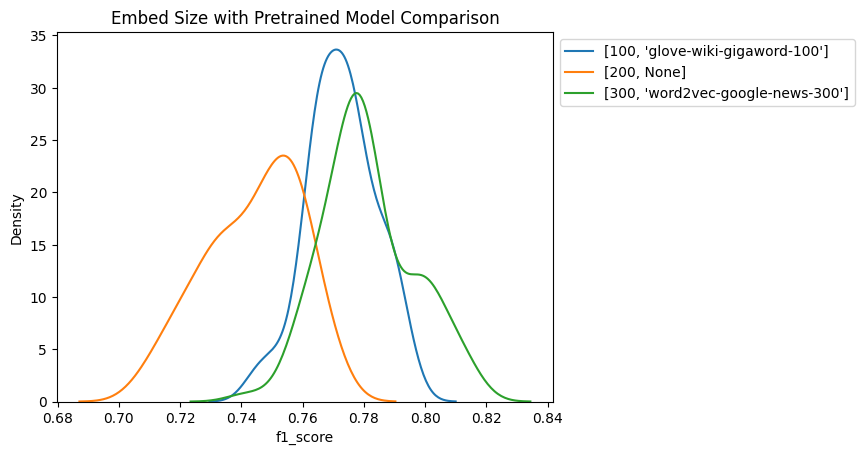

In [26]:
plt.title('Embed Size with Pretrained Model Comparison')
for group, group_df in full_results.groupby('embed_size_with_pretrained_model'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend(bbox_to_anchor=(1, 1))

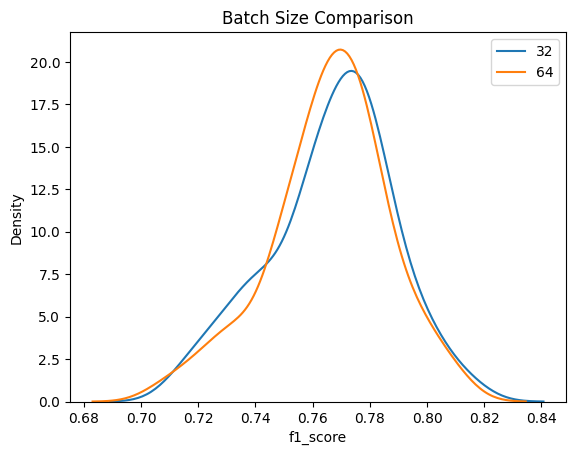

In [27]:
plt.title('Batch Size Comparison')
for group, group_df in full_results.groupby('batch_size'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

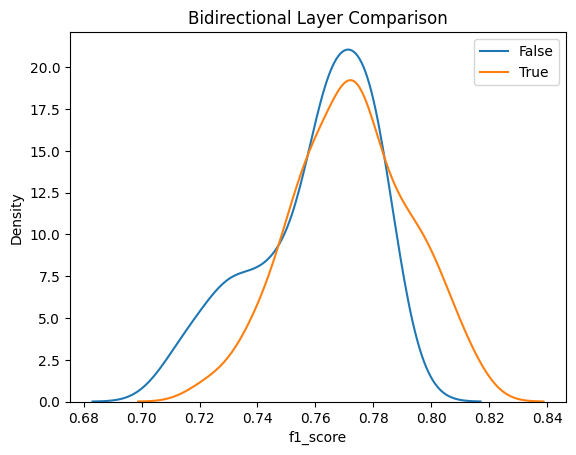

In [28]:
plt.title('Bidirectional Layer Comparison')
for group, group_df in full_results.groupby('bidirectional'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

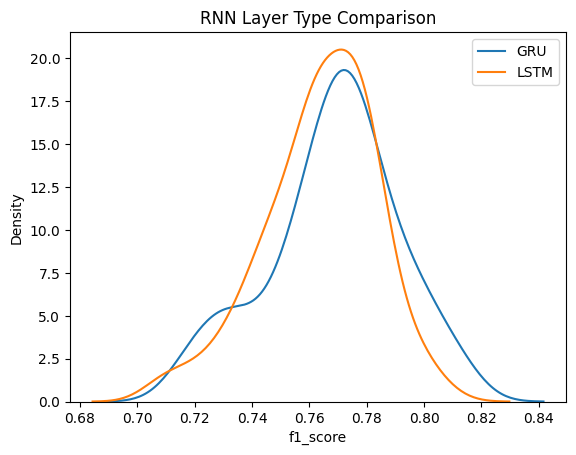

In [29]:
plt.title('RNN Layer Type Comparison')
for group, group_df in full_results.groupby('rnn_layer'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

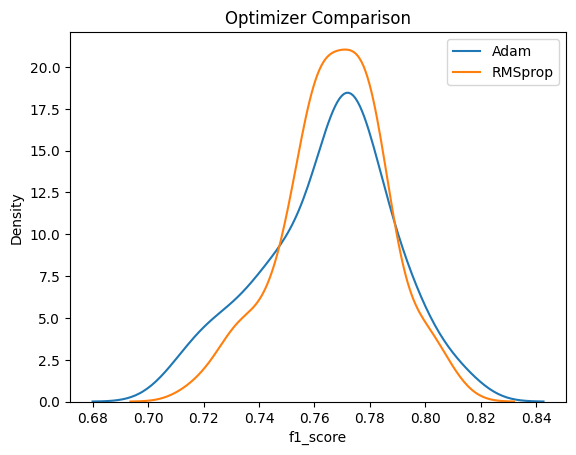

In [30]:
plt.title('Optimizer Comparison')
for group, group_df in full_results.groupby('optimizer'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

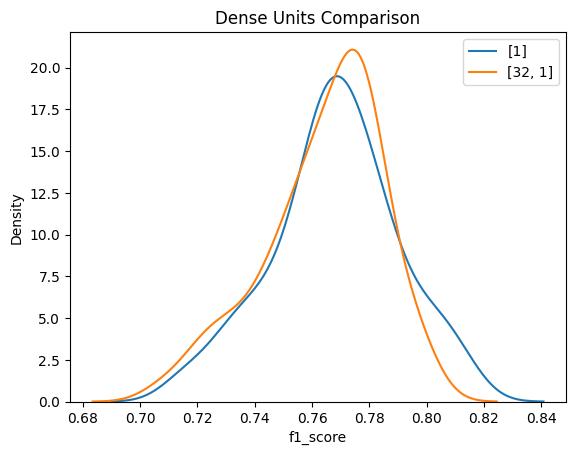

In [31]:
plt.title('Dense Units Comparison')
for group, group_df in full_results.groupby('dense_units'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

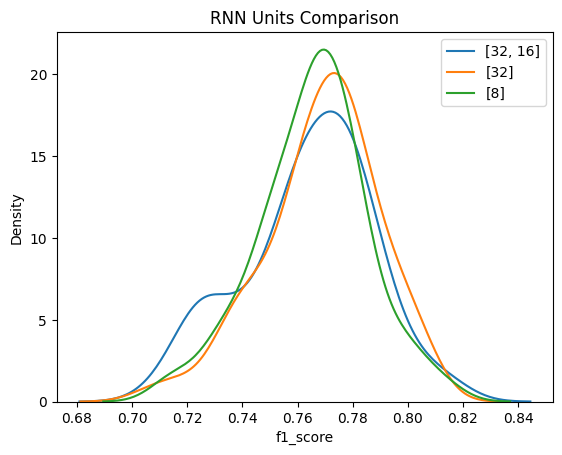

In [32]:
plt.title('RNN Units Comparison')
for group, group_df in full_results.groupby('rnn_units'):
    sns.kdeplot(group_df['f1_score'], label=group)
_ = plt.legend()

After reviewing the charts, I believe that its important for the model to be bidirectional, have GRU units, and use a single unit dense layer. The most important factor that determines the score is the embedding size and the use of a pretrained model. All remaining aspects appear to have a lower impact on the score. Since vocabulary is somewhat related to the embed size, that parameter could be tweaked as well.

---

## Further Tuning and Final Results

Now that the first batch of models have been analyzed, next will be to do more refinement to see if a better model can be created. This time, I will alter only the parameters that relate to vocabulary, embedding size, and the pretrained model. All other configurations will be based off **model-97** from earlier. The model creation can be found in [this notebook here](https://github.com/rpforrest1/RNN_Tweet_Classification_Project/blob/main/model_building/Final_Multi_Model_Building_trained.ipynb).

The only parameters that will change are shown below. This results in **16** new models.
- `vocab_sizes = [2000, 4000, 6000, 8000]`
- `embed_sizes_with_pretrained_model = [[200,'glove-twitter-200'], [300,'word2vec-google-news-300'], [300,'glove-wiki-gigaword-300'], [300,'fasttext-wiki-news-subwords-300']]`

In [33]:
print(bold('Model-97 architecture for reference.'))
display(progress.loc['model97'])

Model-97 architecture for reference.


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model97, dtype: object

In [34]:
# Load results from 2nd round of model building.
progress_final, model_data_final, all_test_metrics_final, full_results_final = load_results('./model_building/model_checkpoints_final')

I'm interested in learning how the different factors affected the 16 new models and if a better model was created.

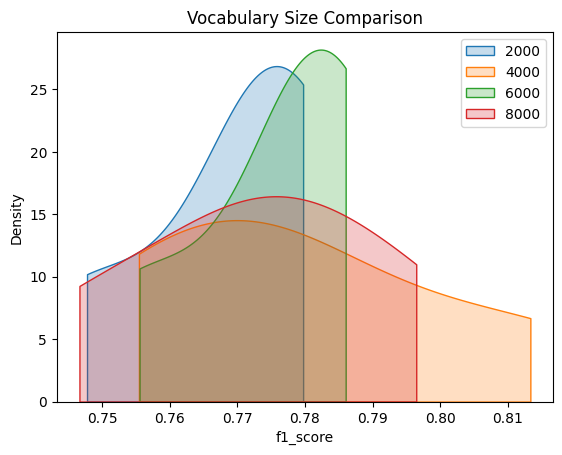

In [35]:
plt.title('Vocabulary Size Comparison')
for group, group_df in full_results_final.groupby('vocab_size'):
    sns.kdeplot(group_df['f1_score'], label=group, cut=0, fill=True)
_ = plt.legend()

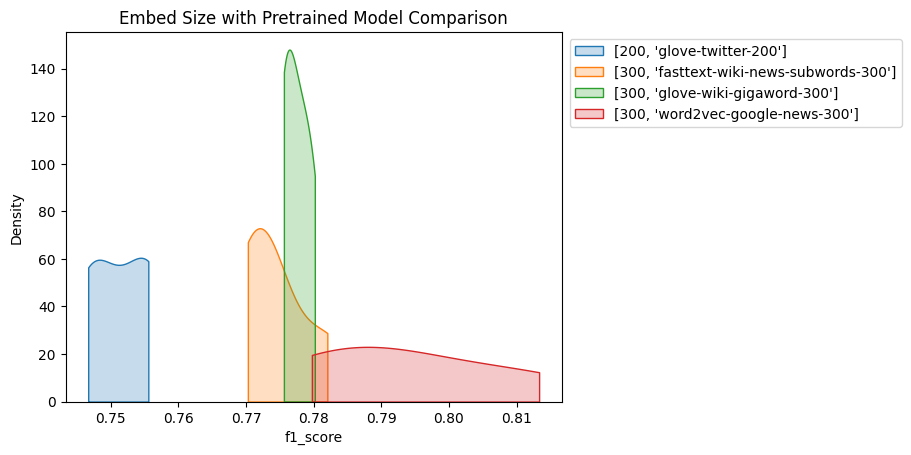

In [36]:
plt.title('Embed Size with Pretrained Model Comparison')
for group, group_df in full_results_final.groupby('embed_size_with_pretrained_model'):
    sns.kdeplot(group_df['f1_score'], label=group, cut=0, fill=True)
_ = plt.legend(bbox_to_anchor=(1.7, 1))

Based on the plots, it looks like a vocabulary size of 4000 is an overall good value. For the pretrained model with embedding size, the word2vec-google-news-300 pretrained model provides the best performance. Given the wide distribution for that model, I believe the vocabulary for the tweet data and the google news data are the most similar.

From these results, I don't believe I was able to create a better model from before. I will take a look at the new test results.

In [37]:
for col in [c for c in all_test_metrics_final.columns if c not in ['loss', 'total_time', 'precision', 'recall']]:
    print(bold(f'Top {col} values on test dataset.'))
    display(all_test_metrics_final.sort_values(col, ascending=False).head(3))
    print('---')

Top accuracy values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model5,0.394028,0.852890,0.897646,0.892683,0.746939,0.813333,82.797449
model13,0.398270,0.838879,0.895637,0.869565,0.734694,0.796460,82.291953
model11,0.411900,0.830123,0.889270,0.870000,0.710204,0.782022,133.910462


---
Top auc values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model5,0.394028,0.852890,0.897646,0.892683,0.746939,0.813333,82.797449
model13,0.398270,0.838879,0.895637,0.869565,0.734694,0.796460,82.291953
model9,0.398821,0.828371,0.895205,0.845070,0.734694,0.786026,71.842647


---
Top f1_score values on test dataset.


,loss,accuracy,auc,precision,recall,f1_score,total_time
model5,0.394028,0.852890,0.897646,0.892683,0.746939,0.813333,82.797449
model13,0.398270,0.838879,0.895637,0.869565,0.734694,0.796460,82.291953
model9,0.398821,0.828371,0.895205,0.845070,0.734694,0.786026,71.842647


---


None of the results stand out as a huge improvement from what was done before. I will submit the 3 best F1-score models to kaggle, but I expect very little improvement if any.

In [38]:
for model_name in ['model5', 'model13', 'model9']:
    if CREATE_SUBMISSION_FILE:
        model = tf.keras.models.load_model(model_data_final[model_name]['checkpoint'])
        final_activation = progress.at[model_name, 'activation']
        model_submission = predict_on_kaggle_test_set(data_dir, model=model, final_activation=final_activation)
        model_submission.to_csv(f'./submissions/{model_name}_submission_final.csv', index=False)
    else:
        print(f'Submission file already created for {model_name}.')

Submission file already created for model5.
Submission file already created for model13.
Submission file already created for model9.


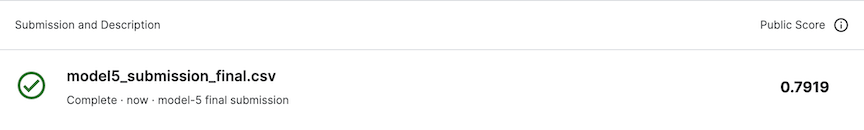  
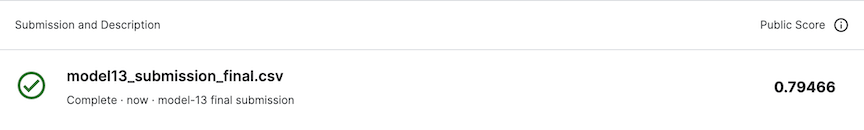  
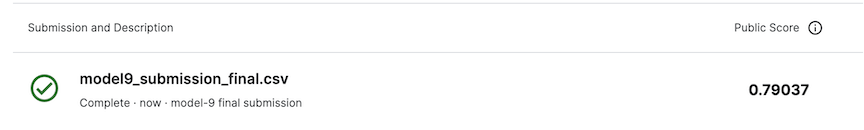

Its good to see that the results are consistantly higher and around the same value. From best to worse for the kaggle scores, it goes model-13 => model-5 => model-9. Ultimately, a better model was created, but not by much. I'll take another look at the configurations used for these models in order to learn more about what is happening.

In [39]:
print(bold('Model configuration for model-13'))
display(progress_final.loc['model13'])

Model configuration for model-13


vocab_size                                                       8000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model13, dtype: object

In [40]:
print(bold('Model configuration for model-5'))
display(progress_final.loc['model5'])

Model configuration for model-5


vocab_size                                                       4000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model5, dtype: object

In [41]:
print(bold('Model configuration for model-9'))
display(progress_final.loc['model9'])

Model configuration for model-9


vocab_size                                                       6000
embed_size_with_pretrained_model    [300, 'word2vec-google-news-300']
batch_size                                                         32
bidirectional                                                    True
rnn_layer                                                         GRU
rnn_units                                                         [8]
dense_units                                                       [1]
activation                                                    sigmoid
final_dropout                                                     0.5
optimizer                                                        Adam
finished                                                         True
Name: model9, dtype: object

So it looks like the best kaggle model was model-13 which had a vocabulary size of 8000. Model-5 is actually the same as model-97 from the first round of training.

The overall winner for the best model is model-13 from the 2nd round of training. I'll take a look at the model history data in order to learn how its training went.

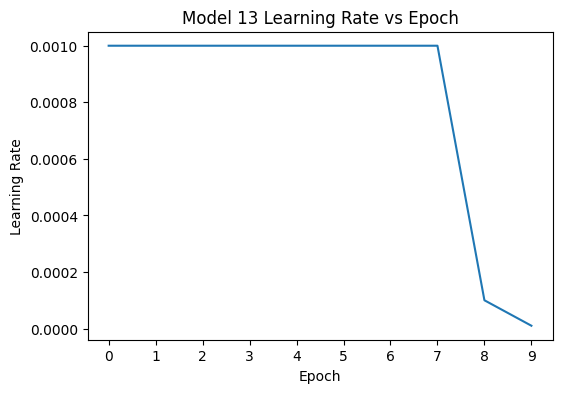

In [42]:
plot_learning_rate(model_data_final['model13']['model_history'], 13)

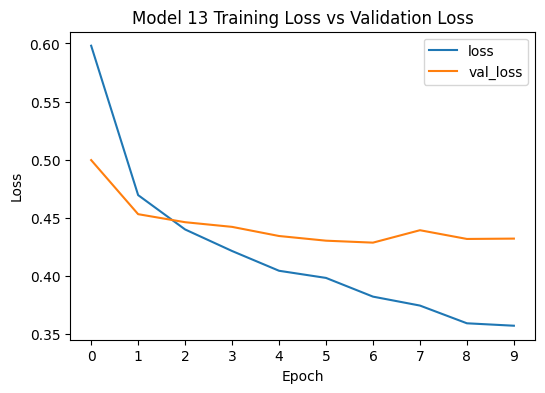

In [43]:
plot_metric(model_data_final['model13']['model_history'], 'loss', 13)

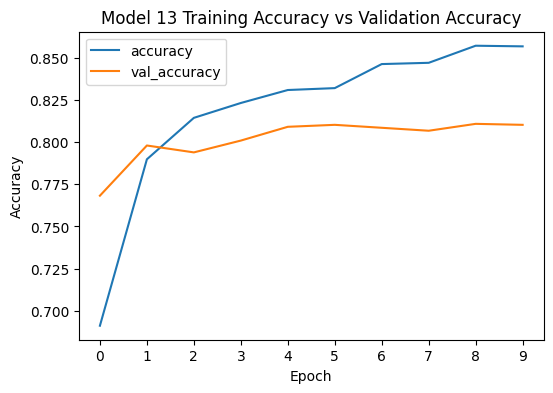

In [44]:
plot_metric(model_data_final['model13']['model_history'], 'accuracy', 13)

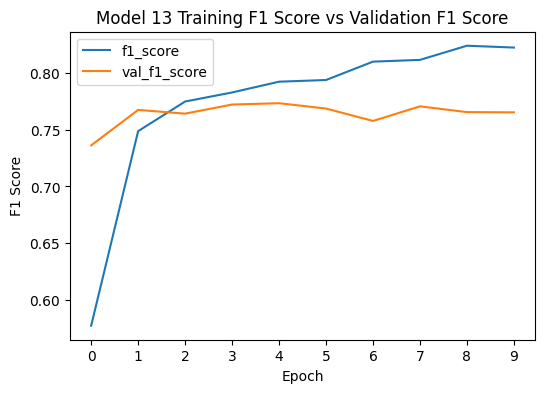

In [45]:
plot_metric(model_data_final['model13']['model_history'], 'f1_score', 13)

Overall the training for model-13 looks like it went ok. The training scores were getting better in all metrics but the validation score was able to stay mostly constant without becoming worse through overfitting. Its interesting to see that not many epochs are needed in order to get a good result.

From the perspective of the model architecture, I believe there is not much else that can be done unless the parameter space was expanded drastically in order to potentially find something new. This will conclude all of the model training for this project.

---

## Conclusion

Overall I learned quite a lot during this project. For this particular task, with only the model architecture and the parameters nailed down, I believe the best place to optimize would be the pieces that happen before the model training. I believe a good baseline for the architecture is to use a vocabulary size of either 4000 or 8000, an embedding size of 300 with the word2vec-google-news-300 pretrained model, a batch size of 32, a single bidirectional GRU layer with 8 units, a dropout layer of 0.5 followed by a single unit dense layer utilizing a sigmoid activation function, and the Adam optimizer. From the training results, it looks like there is not much to gain, but a lot to lose if using a different architecture from the one described. I believe RNN models are efficient on text data, so the architecture doesn't need to be complex like it is with CNNs.  

In order to improve the model, I believe trying some of these options could lead to better results (if only considering continuing to use RNN).
- More careful cleaning of the text data may help. Tweet data is very messy and these tweets are usually created in a way that tries to convey information in a short-hand way.
- Create a new stratification column that combines the keyword with the target category. If the keyword column can act as a 'disaster category' then I believe that attempting to focus on categorizing all types of disasters would lead to better results. Its possible that test performance is low due to not all types of disasters being represented. So making sure there are examples for all the disaster types could be important. Any disaster categories with low counts can be recategorized as 'unknown'.

---

## References

- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://keras.io/examples/nlp/pretrained_word_embeddings
- https://radimrehurek.com/gensim/models/word2vec.html

---